In [65]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import string
from numpy import nan
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import scikitplot
from scipy.sparse import hstack

In [15]:
data = pd.read_csv('cleaned_data.csv')

In [16]:
data.head()

,Unnamed: 0,Video Id,Title,Description,Category
0,0,ehmsJLZlCZ0,ep travelling through north east india off to ...,the journey to arunachal north east india begi...,travel
1,1,e2NQE41J5eM,how do i travel so much how do i earn money,subscribe mountaintrekker gimbal if you have a...,travel
2,2,i9E_Blai8vk,travel vlog welcome to bali priscilla lee,i had the chance to fly out to bali with my wh...,travel
3,3,-LzdIILq5vE,goa travel diary four days in goa travel outfi...,hope you enjoy my goa travel diary this video ...,travel
4,4,7ByoBJYXU0k,steps to becoming a travel blogger,travel blogger nikki vargas of the pin the map...,travel


### deviding the data into train test and validation using 80: 10 :10

In [170]:
X_train,X_test,y_train,y_test = train_test_split(data['Title'].values,data['Category'].values, test_size=.1)
X_train,X_cv,y_train,y_cv = train_test_split(X_train,y_train, test_size=.1)

In [171]:
X_train1,X_test1,y_train1,y_test1 = train_test_split(data['Description'].values,data['Category'].values, test_size=.1)
X_train1,X_cv1,y_train1,y_cv1 = train_test_split(X_train1,y_train1, test_size=.1)

In [172]:
count = 0 
for v in X_train:
    if type(v)!=str:
        X_train[count] = 'x'
    count+=1

In [173]:
count = 0 
for v in X_test:
    if type(v)!=str:
        X_test[count] = 'x'
    count+=1

In [174]:
count = 0 
for v in X_cv:
    if type(v)!=str:
        X_cv[count] = 'x'
    count+=1

In [175]:
count = 0 
for v in X_train1:
    if type(v)!=str:
        X_train1[count] = 'x'
    count+=1
count = 0 
for v in X_test1:
    if type(v)!=str:
        X_test1[count] = 'x'
    count+=1
count = 0 
for v in X_cv1:
    if type(v)!=str:
        X_cv1[count] = 'x'
    count+=1

In [176]:
X_train2 = X_train+X_train1
X_cv2 = X_cv+X_cv1
X_test2 = X_test+X_test1

### converting the Title into numerical vector using tf-idf

In [177]:
tfidf = TfidfVectorizer(1500)
x_train = tfidf.fit_transform(X_train)
x_test = tfidf.transform(X_test)
x_cv = tfidf.transform(X_cv)

In [178]:
tfidf1 = tfidf#TfidfVectorizer(max_features=1000)
x_train1 = tfidf1.fit_transform(X_train1)
x_test1 = tfidf1.transform(X_test1)
x_cv1 = tfidf1.transform(X_cv1)

In [179]:
X_train = hstack((x_train, x_train1))
X_test = hstack((x_test,x_test1))
X_cv = hstack((x_cv,x_cv1))

### applying Logistic Regression over the title:

In [180]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import accuracy_score

In [181]:
train_acc = []
cv_acc = []
print("C ---------> CV Accuracy ********** Train Accuracy")
for c in [.001,.01,.1,1,10,100,1000]:
    model = LR(C=c)
    model.fit(X_train,y_train)
    y_pre = model.predict(X_cv)
    y_pre1 = model.predict(X_train)
    acc = accuracy_score(y_cv,y_pre)
    acc1 = accuracy_score(y_train,y_pre1)
    print(c,"--------->",acc,"**********",acc1)
    cv_acc.append(acc)
    train_acc.append(acc1)

C ---------> CV Accuracy ********** Train Accuracy
0.001 ---------> 0.8946236559139785 ********** 0.9132512845023301
0.01 ---------> 0.946236559139785 ********** 0.9665431951248655
0.1 ---------> 0.9655913978494624 ********** 0.9838690405066316
1 ---------> 0.9817204301075269 ********** 0.9966543195124865
10 ---------> 0.9849462365591398 ********** 1.0
100 ---------> 0.9849462365591398 ********** 1.0
1000 ---------> 0.9838709677419355 ********** 1.0


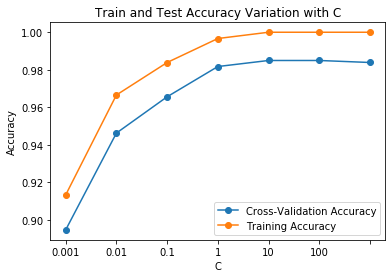

In [182]:
plt.plot(cv_acc,marker='o')
plt.plot(train_acc,marker = 'o')
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("Train and Test Accuracy Variation with C")
plt.xticks(np.arange(7),[.001,.01,.1,1,10,100])
plt.legend(["Cross-Validation Accuracy","Training Accuracy"])
plt.show()

- from the above plot we can see that at C=1, our model's cv accuracy is equivalent to train accuracy but after that it start overfitting so we will choose C = 1 for the final modeling

### Final Evaluation on the test data

In [183]:
model = LR(C=1)
model.fit(x_train,y_train)
y_pre = model.predict(x_test)
y_pre1 = model.predict(x_train)
acc = accuracy_score(y_test,y_pre)
acc1 = accuracy_score(y_train,y_pre1)
print("Training Accuracy of the Model",acc1)
print("Test Accuracy of the Model",acc)

Training Accuracy of the Model 0.9925917074919345
Test Accuracy of the Model 0.9729206963249516


### confusion matrix for test dataset

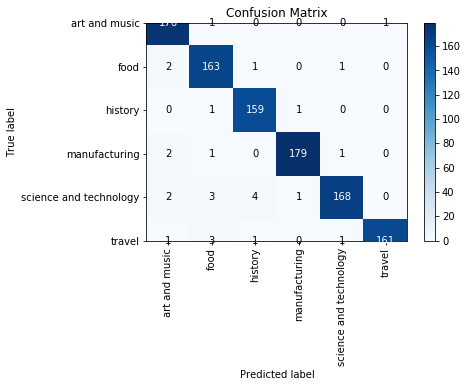

In [184]:
scikitplot.metrics.plot_confusion_matrix(y_test, y_pre,x_tick_rotation=90)
plt.show()

### confusion matrix for train dataset

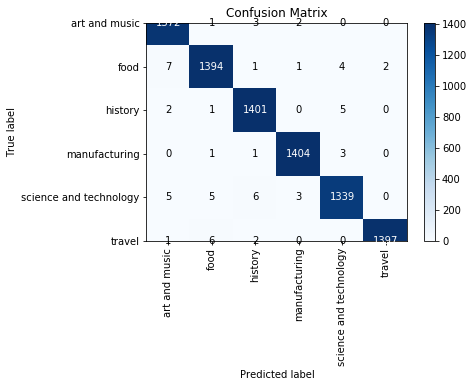

In [185]:
scikitplot.metrics.plot_confusion_matrix(y_train, y_pre1,x_tick_rotation=90)
plt.show()

## Applying Random Forest model

In [186]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier as RF

In [187]:
cv_acc = []
train_acc = []
print("Min Split---n_estimators---max_depth---> Train Accuracy ********** Cross-Val Accuracy")
for s in [2,3,4,5,6,7]:
    for tree in [20,40,60,80,100,125,150,180,200]:
        for d in [10,11,12]:
            model = RF(n_estimators=tree,max_depth = d,min_samples_split = s)
            model.fit(x_train,y_train)
            y_pre = model.predict(x_cv)
            y_pre1 = model.predict(x_train)
            acc = accuracy_score(y_cv,y_pre)
            acc1 = accuracy_score(y_train,y_pre1)
            print(s,"------------",tree,"---",d,"---> ",acc1," **********",acc)
            cv_acc.append(acc)
            train_acc.append(acc1)
            print("**********"*5)

Min Split---n_estimators---max_depth---> Train Accuracy ********** Cross-Val Accuracy
2 ------------ 20 --- 10 --->  0.9338033217827697  ********** 0.9258064516129032
**************************************************
2 ------------ 20 --- 11 --->  0.8891145895566973  ********** 0.875268817204301
**************************************************
2 ------------ 20 --- 12 --->  0.9315330385948142  ********** 0.9182795698924732
**************************************************
2 ------------ 40 --- 10 --->  0.9579400167284025  ********** 0.9473118279569892
**************************************************
2 ------------ 40 --- 11 --->  0.9547138248297288  ********** 0.946236559139785
**************************************************
2 ------------ 40 --- 12 --->  0.9563866650734855  ********** 0.9505376344086022
**************************************************
2 ------------ 60 --- 10 --->  0.965348309236468  ********** 0.9591397849462365
********************************************

4 ------------ 60 --- 12 --->  0.9680965467797825  ********** 0.9612903225806452
**************************************************
4 ------------ 80 --- 10 --->  0.9697693870235392  ********** 0.9634408602150538
**************************************************
4 ------------ 80 --- 11 --->  0.9674991038355837  ********** 0.9559139784946237
**************************************************
4 ------------ 80 --- 12 --->  0.9726371131556937  ********** 0.9591397849462365
**************************************************
4 ------------ 100 --- 10 --->  0.9695304098458597  ********** 0.964516129032258
**************************************************
4 ------------ 100 --- 11 --->  0.9712032500896164  ********** 0.9634408602150538
**************************************************
4 ------------ 100 --- 12 --->  0.9710837615007767  ********** 0.964516129032258
**************************************************
4 ------------ 125 --- 10 --->  0.9710837615007767  ********** 0.9677419354

6 ------------ 125 --- 11 --->  0.9741904648106106  ********** 0.9666666666666667
**************************************************
6 ------------ 125 --- 12 --->  0.9743099533994504  ********** 0.9666666666666667
**************************************************
6 ------------ 150 --- 10 --->  0.9700083642012188  ********** 0.9655913978494624
**************************************************
6 ------------ 150 --- 11 --->  0.973473533277572  ********** 0.9698924731182795
**************************************************
6 ------------ 150 --- 12 --->  0.9745489305771299  ********** 0.9688172043010753
**************************************************
6 ------------ 180 --- 10 --->  0.9680965467797825  ********** 0.9580645161290322
**************************************************
6 ------------ 180 --- 11 --->  0.9757438164655275  ********** 0.967741935483871
**************************************************
6 ------------ 180 --- 12 --->  0.9761022822320469  ********** 0.963440

In [188]:
model = RF(n_estimators=150,max_depth = 12,min_samples_split=3)
model.fit(x_train,y_train)
y_pre = model.predict(x_test)
y_pre1 = model.predict(x_train)
acc = accuracy_score(y_test,y_pre)
acc1 = accuracy_score(y_train,y_pre1)
print("Training Accuracy of the model: ",acc1)
print("Test Accuracy of the model: ",acc)

Training Accuracy of the model:  0.9761022822320469
Test Accuracy of the model:  0.9593810444874274


In [189]:
feature_names=tfidf.get_feature_names()
w=model.feature_importances_
top_f=zip(feature_names,w)
top_new=list(top_f)
top_new.sort(reverse=True,key=lambda x:x[1])
top_20=top_new[0:20]
print("Top 20 Features According to Random Forest:")
print("********************************************")
top_20

Top 20 Features According to Random Forest:
********************************************


[('focal', 0.06972268675376907),
 ('lavidaazul', 0.049007334482257484),
 ('mershin', 0.043508884338904735),
 ('mammoth', 0.04316614051875116),
 ('audrey', 0.038521866966130205),
 ('aleksa', 0.03596414625066864),
 ('creationism', 0.03317749948871801),
 ('amateur', 0.030783871487701616),
 ('mass', 0.02787845056493373),
 ('kenan', 0.02702472356356211),
 ('mercury', 0.024571806729432353),
 ('disco', 0.02028202951012102),
 ('brar', 0.019413436705964314),
 ('gmp', 0.016871096175057724),
 ('broadway', 0.015960650952657026),
 ('almost', 0.01582816188406798),
 ('impressive', 0.015018716777948346),
 ('classics', 0.013689830700366811),
 ('alma', 0.013543363899627993),
 ('creativebuttonart', 0.01216482898055987)]